In [81]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  

sns.set_style("whitegrid")

In [82]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Number of student IDs in act_11_df that are also in vendorUsage: 609
Percentage of act_11_df students also in vendorUsage: 18.20%


# actMath_11_df

## Data exploration

In [115]:
actMath_11_df = pd.read_csv('dataframes/actMath_11.csv')

In [116]:
# Shape should be (3837, 239)
print(actMath_11_df.shape)
actMath_11_df.head()

(3837, 239)


,studentId,is_proficient,proficient_score,proficient_diff,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,course_VarFBI,cours

In [117]:
# Check for class imbalance
actMath_11_df['is_proficient'].value_counts()

is_proficient
False    2234
True     1603
Name: count, dtype: int64

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_53323/2289246554.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=actMath_11_df, x='proficient_score', shade=True)


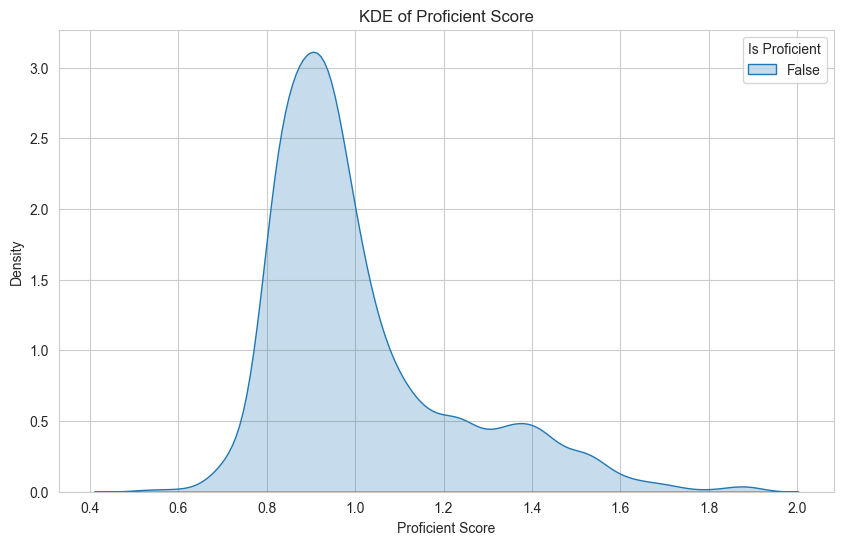

In [118]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=actMath_11_df, x='proficient_score', shade=True)
plt.title('KDE of Proficient Score')
plt.xlabel('Proficient Score')
plt.ylabel('Density')
plt.legend(title='Is Proficient', labels=['False', 'True'])
plt.show()

In [119]:
# Count the number of students enrolled in each course
course_enrollment = actMath_11_df.iloc[:, 2:].sum().sort_values(ascending=False)

# Print the number of students enrolled in each course, sorted by most popular
print("Number of students enrolled in each course:")
for course, count in course_enrollment.items():
    if count > 0:
        print(f"{course}: {count}")

Number of students enrolled in each course:
proficient_score: 3871.058823529412
course_Physical Sci: 1776.0
course_English Gr10: 1721.0
course_D&TSafetyEd: 1450.0
course_Health 9-12: 1394.0
course_Algebra I B: 1229.0
course_USHis I G10: 1199.0
school_High School C: 994.0
course_Mustang Advi: 994.0
school_High School D: 933.0
course_Eng Gr10 Adv: 927.0
course_ChemistryAdv: 735.0
course_USHis I Adv: 704.0
course_Geometry: 659.0
course_HEALTH 9-12: 647.0
course_DRIVERS ED: 609.0
proficient_diff: 579.0
course_US His-1877: 483.0
course_CareerPrep-B: 472.0
school_High School A: 442.0
course_Panther Adv: 442.0
school_High School B: 410.0
course_Alg II/Trig: 406.0
course_BullBogAdv: 340.0
course_LIFE PE 9-12: 308.0
course_Spanish 1: 283.0
course_FACS: 247.0
course_VarFBII: 208.0
course_Fund Agrisci: 186.0
course_Theatre I: 178.0
course_ALIITRIGH/A: 176.0
course_HS US 10 ADV: 172.0
course_Spanish 2: 171.0
course_ARMY LET II: 169.0
course_StudyHall912: 166.0
course_VisArtI.5C: 165.0
course_Fit/C

In [120]:
course_enrollment_top50 = course_enrollment.head(50)

Use only the 50 most enrolled courses.

In [121]:
actMath_11_top50_df = actMath_11_df.drop(columns=[col for col in actMath_11_df.columns if col.startswith('course_') and col not in course_enrollment_top50.index])

In [122]:
actMath_11_top50_df.head()

,studentId,is_proficient,proficient_score,proficient_diff,course_ALIITRIGH/A,course_ARMY LET II,course_Agriscience,course_Alg II/Trig,course_Algebra I B,course_BAND MARCH,course_BANDCONCERT,course_BandMarch.5C,course_BullBogAdv,course_CareerPrep-B,course_ChemistryAdv,course_D&TSafetyEd,course_DRIVERS ED,course_Eng Gr10 Adv,course_English Gr10,course_FACS,course_Fit/Cond,course_Food Nutritn,course_Fund Agrisci,course_GEOM ADV,course_Geometry,course_Geometry Adv,course_HEALTH 9-12,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_Int Metl Fab,course_Intermed Agr,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_Music App,course_Mustang Advi,course_Panther Adv,course_Phy Sci Adv,course_Physical Sci,course_Spanish 1,course_Spanish 2,course_StudyHall912,course_Theatre I,course_US His-1877,course_USHis I Adv,course_USHis I G10,course_VarFBII,course_VisArtI.5C,school_High School A,school_High School B,school_High School C,school_High School D
0,45054,False,0.529412,-8.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,45054,False,0.529412,-8.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,45440,False,0.941176,-1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,45440,False,0.941176,-1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,45440,False,0.941176,-1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Train models

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Logistic regression with top50 courses, binary label

In [124]:
# Separate features and target variable
X = actMath_11_top50_df.drop(['studentId', 'is_proficient', 'proficient_score', 'proficient_diff'], axis=1)
y = actMath_11_top50_df['is_proficient']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=actMath_11_top50_df['is_proficient'])

# Create a logistic regression model
model = LogisticRegression(penalty='l2', solver='lbfgs', random_state=123)
model.fit(X_train, y_train)
y_pred =model.predict(X_test)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print the top 10 most important features
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': np.abs(model.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.93      0.83       447
        True       0.84      0.56      0.67       321

    accuracy                           0.77       768
   macro avg       0.79      0.74      0.75       768
weighted avg       0.79      0.77      0.76       768


Confusion Matrix:
[[414  33]
 [142 179]]

Top 10 Most Important Features:
                feature  importance
3    course_Alg II/Trig    1.670136
33   course_Phy Sci Adv    1.556969
4    course_Algebra I B    1.118991
23  course_HISTUS1877AC    1.066674
43    course_VisArtI.5C    0.995834
7   course_BandMarch.5C    0.962792
15          course_FACS    0.947753
10  course_ChemistryAdv    0.942650
8     course_BullBogAdv    0.892873
37  course_StudyHall912    0.858108


### Linear regression with top50 courses, continuous label

In [256]:
# Separate features and target variable
X = actMath_11_top50_df.drop(['studentId', 'is_proficient', 'proficient_score', 'proficient_diff'], axis=1)
y = actMath_11_top50_df['proficient_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=actMath_11_top50_df['is_proficient'])

# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_continuous = model.predict(X_test)

# Should predict >1.0 if proficient, <1.0 if not proficient
threshold = 1.2  # ADJUST
y_pred_bool = y_pred_continuous >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_bool, y_pred_bool))

# Print the top 10 most important features
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': np.abs(model.coef_)})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

threshold= 1.2

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.93      0.92       644
        True       0.58      0.52      0.55       124

    accuracy                           0.86       768
   macro avg       0.74      0.72      0.73       768
weighted avg       0.86      0.86      0.86       768


Confusion Matrix:
[[596  48]
 [ 59  65]]

Top 10 Most Important Features:
                 feature    importance
47  school_High School C  1.302425e+11
31   course_Mustang Advi  1.302425e+11
32    course_Panther Adv  2.997088e+10
45  school_High School A  2.997088e+10
3     course_Alg II/Trig  1.618876e-01
0     course_ALIITRIGH/A  1.432599e-01
10   course_ChemistryAdv  1.029011e-01
33    course_Phy Sci Adv  9.511964e-02
4     course_Algebra I B  9.464047e-02
46  school_High School B  8.192498e-02


### Neural network with top50 courses, binary label

In [216]:
# Define a custom dataset
class TabularDataSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values).reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the neural network
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Prepare the data
X = actMath_11_top50_df.drop(['studentId', 'is_proficient', 'proficient_score'], axis=1)
y = actMath_11_top50_df['is_proficient']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=actMath_11_top50_df['is_proficient'])

# Create datasets and dataloaders
train_dataset = TabularDataSet(X_train, y_train)
test_dataset = TabularDataSet(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
input_size = X.shape[1]
model = Net(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predicted = (outputs > 0.5).float()
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        y_true.extend(batch_y.numpy())
        y_pred.extend(predicted.numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))




Epoch [10/100], Loss: 0.4392
Epoch [20/100], Loss: 0.5163
Epoch [30/100], Loss: 0.3892
Epoch [40/100], Loss: 0.3138
Epoch [50/100], Loss: 0.3537
Epoch [60/100], Loss: 0.3971
Epoch [70/100], Loss: 0.3172
Epoch [80/100], Loss: 0.3649
Epoch [90/100], Loss: 0.3110
Epoch [100/100], Loss: 0.3230
Test Accuracy: 78.52%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83       447
         1.0       0.82      0.62      0.71       321

    accuracy                           0.79       768
   macro avg       0.79      0.76      0.77       768
weighted avg       0.79      0.79      0.78       768


Confusion Matrix:
[[403  44]
 [121 200]]


False negative (someone who is not proficient but predicted to be proficient) is worse than false positive, so focus on recall. 

In [217]:
courses_by_subject = {
    "Math": [
        "course_Algebra I B", "course_Algebra I A", "course_Algebra I", "course_AlgebraicCon",
        "course_Alg II/Trig", "course_ALIITRIGH/A", "course_Alg Esntls B", "course_Algebra II",
        "course_Alg II/TrigAC", "course_Geometry", "course_Geometry Adv", "course_GeometryACCE",
        "course_GEOM ADV", "course_Alg I B ACCE", "course_AlgEnrichmet"
    ],
    "Science": [
        "course_Physical Sci", "course_Phy Sci Adv", "course_Biology", "course_Chemistry",
        "course_ChemistryAdv", "course_Biology Adv", "course_BIOLOGY ADV", "course_Anat/Physio", 
        "course_Marine Sci", "course_Ear/SpaceSci", "course_Enviro Sci", "course_For/Cri Inve", 
        "course_Forestry", "course_Intermed Agr", "course_Agriscience", "course_Advanced Agr", 
        "course_Fund Agrisci"
    ],
    "English": [
        "course_English Gr10", "course_Eng Gr10 Adv", "course_English Gr11", "course_EngLang,BS10", 
        "course_Eng Ess 10", "course_Eng Ess 11", "course_Eng Ess 11", "course_EngGr9-CR", 
        "course_EngEss: Phy Sci", "course_Ess: Phy Sci", "course_English Gr 9", "course_EnglGr10ACCE"
    ],
    "History": [
        "course_USHis I G10", "course_USHis I Adv", "course_US His-1877", "course_HISTUS1877AC", 
        "course_USHis InD-P", "course_HS US 10 ADV", "course_Enviro Sci", "course_USHisIG10ACC", 
        "course_USHis 1877-P", "course_WH 1500-P", "course_WH 1500-P Adv", "course_WH1500-P-CR"
    ],
    "Foreign Language": [
        "course_Spanish 1", "course_Spanish 2", "course_Spanish 3", "course_SPANISH I", 
        "course_SPANISH II", "course_SpanIACC", "course_SPAN II ACCE", "course_FrenchIACCE", 
        "course_German1ACCES", "course_LATIN 1 ACC"
    ]
}